## A/B Testing Analysis

In this analysis, we explored the impact of different versions of product pages, landing pages, and checkout pages on user conversion rates. Our dataset contained user interactions, including whether they were exposed to the control (old page) or treatment (new page) and whether they converted or not.

In [2]:
import pandas as pd

# Load the dataset
ab_test_data = pd.read_csv('/Users/bram/Downloads/archive/ab_test.csv')
ab_test_data.head()

,id,time,con_treat,page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


The dataset contains the following columns:

id: It appears to be a unique identifier for each user or visit.
time: The time of the visit. It seems to be in the format hh:mm.s.
con_treat: This indicates whether the user was part of the control group (receiving the old version) or the treatment group (receiving the new version).
page: This further specifies which version of the page the user saw (old_page or new_page).
converted: A binary variable indicating whether the user converted (1 for yes, 0 for no).
Now, let's define our goals for the A/B test analysis. 

Here are the framework i'm gonna use:
Check Data Consistency: Ensure that users in the control group only see the old page and those in the treatment group see the new page. If there are discrepancies, it could impact the results.
Descriptive Analysis: Understand the conversion rates for both groups.
Hypothesis Testing: Test if there's a statistically significant difference in conversion rates between the two groups.
Conclusion & Recommendation: Based on the results, make a recommendation on whether to implement the new page or stick with the old one.

In [5]:
ab_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         294478 non-null  int64 
 1   time       294478 non-null  object
 2   con_treat  294478 non-null  object
 3   page       294478 non-null  object
 4   converted  294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


Check data consitency

In [8]:
# Check for inconsistencies in the data

# Create a pivot table to see the counts of each combination of 'con_treat' and 'page'
inconsistency_check = ab_test_data.pivot_table(index='con_treat', columns='page', values='id', aggfunc='count').fillna(0)

inconsistency_check


page,new_page,old_page
con_treat,,
control,1928,145274
treatment,145311,1965


The table above shows the counts of each combination of 'con_treat' (control/treatment) and 'page' (old_page/new_page).

From the data:

There are 1,928 instances where users in the control group saw the new page, which is inconsistent.
There are 1,965 instances where users in the treatment group saw the old page, which is also inconsistent.
These inconsistencies may arise due to various reasons like logging errors, user behavior (e.g., using cached versions), or other technical issues.

So we have to handle by reassign based on group

In [9]:
# Reassign groups based on the 'page' column

# If page is 'old_page', assign 'control' to 'con_treat', else assign 'treatment'
ab_test_data['con_treat'] = ab_test_data['page'].apply(lambda x: 'control' if x == 'old_page' else 'treatment')

# Check the data consistency again
reassigned_check = ab_test_data.pivot_table(index='con_treat', columns='page', values='id', aggfunc='count').fillna(0)

reassigned_check


page,new_page,old_page
con_treat,,
control,0.0,147239.0
treatment,147239.0,0.0



The groups have been successfully reassigned based on the pages:

All users in the control group now see the old page.
All users in the treatment group now see the new page.

Now move to descriptive analysis.

In [10]:
# Check for missing data in the dataset
missing_data = ab_test_data.isnull().sum()

missing_data


id           0
time         0
con_treat    0
page         0
converted    0
dtype: int64

There are no missing values in the dataset for any of the columns. We can proceed with the analysis without any concerns related to missing data.
Let's move to compute the conversion rates

### Initial Analysis

In [3]:
conversion_rates = ab_test_data.groupby('con_treat')['converted'].mean()
conversion_rates

con_treat
control      0.120399
treatment    0.118920
Name: converted, dtype: float64

The descriptive analysis reveals the following conversion rates:

Control Group (old page): 
12.05%
Treatment Group (new page): 
11.88%
At a glance, the old page (control group) has a slightly higher conversion rate than the new page (treatment group).

However, to determine if this difference is statistically significant or if it occurred by chance, we need to conduct a hypothesis test.

For this A/B test, our hypotheses are:

Null Hypothesis (H0): The conversion rate of the old page is greater than or equal to the conversion rate of the new page.
Alternative Hypothesis (H1): The conversion rate of the old page is less than the conversion rate of the new page.



We need to consider the confounding variables, to ensure we have valid conclusions.
From the dataset, the potential confounding variables that we have are, and how we address them:

1. Time: The 'time' column indicates when a user visited the page. There could be variations in conversion rates based on the time of day, day of the week, or specific events.
    Action: We can aggregate conversion rates by different time periods and check if there's a noticeable pattern.

2. User Characteristics: Even though we don't have explicit user attributes, differences in user behavior based on demographics, device type, browser, location, etc., can influence conversion rates.
    Action: If additional data on user characteristics is available, we should incorporate it into the analysis. Otherwise, random assignment to treatment and control groups should help ensure an even distribution of these unobserved characteristics.

3. Duration of Experiment: If the test was run for a short duration, it might be influenced by short-term behaviors or events.
    Action: Ensure that the A/B test runs for an adequate time to capture typical user behaviors.

4. Previous Experience: Users who have seen the old page before might have a different reaction when they see the new page, compared to new users.
    Action: If we have data on repeat visits or user histories, it would be worth examining.

5. Technical Issues: Sometimes, the implementation of a new page might come with technical glitches, slower load times, or other issues that could negatively impact user experience and, consequently, conversion rates.
    Action: Ensure that the new page's technical performance is on par with the old page.

In [11]:
# Start from conversion time over time different period first

# Convert the 'time' column to a datetime format for easier analysis
ab_test_data['time'] = pd.to_datetime(ab_test_data['time'], format='%H:%M.%S').dt.time

# Extract hour from the 'time' column
ab_test_data['hour'] = ab_test_data['time'].apply(lambda x: x.hour)

# Group by 'hour' and 'con_treat' to calculate conversion rates for each hour
conversion_by_hour = ab_test_data.groupby(['hour', 'con_treat'])['converted'].mean().unstack()

conversion_by_hour


ValueError: time data '55:06.2' does not match format '%H:%M.%S' (match)

It seems that there's an error in the format of some time entries. The format '%H:%M.%S' expects hours to be between 00 and 23, but we have values like '55:06.2'. This indicates that the 'time' column might not represent standard time values.

We should inspect the time column to get a clearer picture

In [12]:
# Extract the hour component from the 'time' column (before the first colon) and get unique values
unique_hours = ab_test_data['time'].apply(lambda x: int(x.split(':')[0])).unique()

unique_hours


array([11,  1, 55, 28, 52, 20, 26, 48, 58, 37,  5, 31, 45, 33, 59, 36, 12,
       38, 35, 29, 50, 22, 27, 39, 23, 24, 18,  3,  7, 25, 10, 49, 15, 47,
       51, 16, 54, 19,  2, 57,  9,  0, 44, 34, 14, 30, 21,  8, 17, 42,  4,
       43, 13, 40, 41, 56, 46, 53,  6, 32])

The unique hour values extracted from the 'time' column range from 0 to 59, which confirms that the 'time' format isn't standard hours, minutes, and seconds. Instead, it seems to follow a minutes:seconds.milliseconds format.

Given this we'll extract the minutes (which we initially thought were hours) and analyze the conversion rates by these time periods. 

In [13]:
# Extract minutes from the 'time' column and assign it to a new column 'minutes'
ab_test_data['minutes'] = ab_test_data['time'].apply(lambda x: int(x.split(':')[0]))

# Group by 'minutes' and 'con_treat' to calculate conversion rates for each minute
conversion_by_minutes = ab_test_data.groupby(['minutes', 'con_treat'])['converted'].mean().unstack()

conversion_by_minutes.head()


con_treat,control,treatment
minutes,,
0,0.119920,0.118090
1,0.128516,0.112245
2,0.118721,0.122084
3,0.125988,0.125511
4,0.123798,0.109362


The table above shows the conversion rates for both control (old page) and treatment (new page) groups, broken down by each minute interval.

To better visualize these patterns, we can plot the conversion rates over time for both groups. This will help us see if there are specific time periods where one version performs notably better or worse than the other.

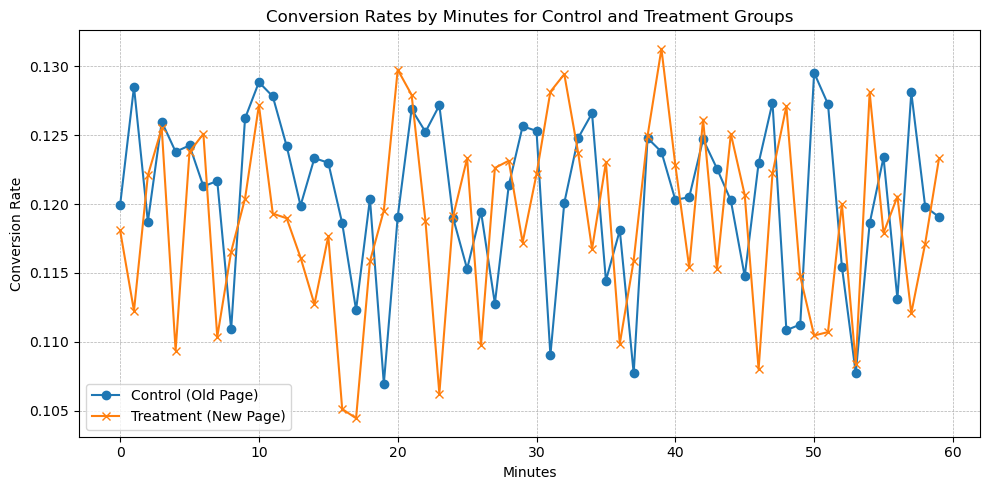

In [16]:
# visualize
import matplotlib.pyplot as plt

# Plot the conversion rates by minutes
plt.figure(figsize=(10, 5))
plt.plot(conversion_by_minutes.index, conversion_by_minutes['control'], label='Control (Old Page)', marker='o')
plt.plot(conversion_by_minutes.index, conversion_by_minutes['treatment'], label='Treatment (New Page)', marker='x')
plt.xlabel('Minutes')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rates by Minutes for Control and Treatment Groups')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


The graph visualizes the conversion rates for both the control (old page) and treatment (new page) groups over different minute intervals.

Key Observations:

1. The conversion rates for both groups fluctuate across different time intervals.
2. There doesn't appear to be a consistent trend where one page performs significantly better than the other across all time periods.
3. Both pages have periods of peaks and troughs, suggesting that external factors (possibly related to the time of visit) can influence user behavior.

### Hypothesis Testing
Null Hypothesis (H0): The conversion rate of the old page is greater than or equal to the conversion rate of the new page.
Alternative Hypothesis (H1): The conversion rate of the old page is less than the conversion rate of the new page.

We'll use a two-sample proportion z-test to test these hypotheses. The z-test is appropriate here because:
1. We're dealing with proportions (conversion rates).
2. We have a large sample size.

In [18]:
# calculate z-score and p-value
from statsmodels.stats.proportion import proportions_ztest

# Number of successes (conversions) for control and treatment groups
count = [ab_test_data[ab_test_data['con_treat'] == 'control']['converted'].sum(),
         ab_test_data[ab_test_data['con_treat'] == 'treatment']['converted'].sum()]

# Total number of observations for control and treatment groups
nobs = [len(ab_test_data[ab_test_data['con_treat'] == 'control']),
        len(ab_test_data[ab_test_data['con_treat'] == 'treatment'])]

# Two-sample proportion z-test
z_score, p_value = proportions_ztest(count, nobs, alternative='smaller')

print("Z-score is",z_score, "and P-value is",p_value)


Zscore adalah 1.3683341399998907 dan P-value sebesar 0.9143962454534289


Given the high p-value, we fail to reject the null hypothesis (H0). This means that there isn't sufficient evidence to suggest that the conversion rate of the old page is less than the conversion rate of the new page.

In other words, based on this test, the new page does not demonstrate a statistically significant improvement in conversion rate over the old page.

However, it's essential to remember that "failing to reject the null hypothesis" doesn't mean that the old page is better; it simply means that we don't have strong evidence from this test to say that the new page is superior. 

Therefore we could try causal inference, when hypothesis testing fails to reject the null hypothesis, it only tells us that there's not enough evidence to detect a statistically significant difference between groups. It doesn't necessarily indicate the absence of a causal relationship.

The approach is using Propensity Score Matching (PSM): 
This method is used to control for confounding in observational studies. The idea is to match each treated unit (in our case, users exposed to the new page) with a non-treated unit (users exposed to the old page) that has a similar probability (or propensity) of receiving the treatment. This probability is calculated based on observed characteristics. After matching, the difference in outcomes between matched pairs approximates the causal effect.

For this analysis we can add Country dataset which each ID is corresponding to each Country

In [19]:

# adding data
countries_data = pd.read_csv('/Users/bram/Downloads/archive/countries_ab.csv')

# Display the first few rows of the dataset
countries_data.head()


,id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


The countries_ab.csv dataset contains two columns:

id: This appears to be a unique identifier for each user, which can be used to merge with our main A/B test dataset.
country: The country associated with each user.
To proceed:

We'll merge the country data with our main A/B test dataset using the id column.
We'll then examine the conversion rates by country for both the control and treatment groups. This will give us an understanding of whether the country could be a confounding factor in our analysis.

In [21]:
# Merge the main A/B test data with the countries data on 'id'
merged_data = ab_test_data.merge(countries_data, on='id', how='left')

# Group by 'country' and 'con_treat' to calculate conversion rates for each country
conversion_by_country = merged_data.groupby(['country', 'con_treat'])['converted'].mean().unstack()

conversion_by_country


con_treat,control,treatment
country,,
CA,0.119342,0.112492
UK,0.119841,0.121327
US,0.120785,0.118415


The table above displays the conversion rates for both the control (old page) and treatment (new page) groups, broken down by country:

Canada (CA): The control group has a slightly higher conversion rate than the treatment group.
United Kingdom (UK): The treatment group (new page) has a higher conversion rate than the control group.
United States (US): The control group has a slightly higher conversion rate than the treatment group.
From these results, we observe variations in conversion rates based on the country. This suggests that country might play a role in influencing the conversion rates and could act as a confounder.

To determine if the differences in conversion rates across countries are statistically significant, we can incorporate country as a variable in our propensity score matching analysis

Propensity Score Matching with Country as a Confounder
Given our setup, the steps are as follows:

Estimation of Propensity Scores:
Use logistic regression to estimate the propensity scores. The dependent variable is the treatment assignment (whether a user saw the new page or old page), and the independent variables include the country.
Matching:
Match each treated unit (users who saw the new page) with a control unit (users who saw the old page) based on the propensity scores.
Assess Balance:
After matching, verify if the distribution of the country variable is balanced across the treatment and control groups.
Estimate Treatment Effect:
Calculate the average treatment effect on the treated (ATT) by comparing the conversion rates between the matched pairs.

We'll now match each treated user (those who saw the new page) with a control user (those who saw the old page) based on the propensity scores. For simplicity, we'll use nearest neighbor matching.

In [23]:
import statsmodels.api as sm

# Convert country to dummy variables
merged_data = pd.get_dummies(merged_data, columns=['country'], drop_first=True)

# Prepare data for logistic regression
X = merged_data[['country_UK', 'country_US']]
X = sm.add_constant(X)  # Add a constant for the intercept
y = merged_data['con_treat'].apply(lambda x: 1 if x == 'treatment' else 0)

# Fit logistic regression model
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# Extract the propensity scores
merged_data['propensity_score'] = result.predict(X)

merged_data.head()


Optimization terminated successfully.
         Current function value: 0.693144
         Iterations 3


,id,time,con_treat,page,converted,minutes,country_UK,country_US,propensity_score
0,851104,11:48.6,control,old_page,0,11,0,1,0.500315
1,804228,01:45.2,control,old_page,0,1,0,1,0.500315
2,661590,55:06.2,treatment,new_page,0,55,0,1,0.500315
3,853541,28:03.1,treatment,new_page,0,28,0,1,0.500315
4,864975,52:26.2,control,old_page,1,52,0,1,0.500315


In [24]:
# match the data
from sklearn.neighbors import NearestNeighbors

# Split the data into treatment and control groups
treatment_data = merged_data[merged_data['con_treat'] == 'treatment']
control_data = merged_data[merged_data['con_treat'] == 'control']

# Use Nearest Neighbors for matching
nbrs = NearestNeighbors(n_neighbors=1).fit(control_data[['propensity_score']])
distances, indices = nbrs.kneighbors(treatment_data[['propensity_score']])

# Create a dataframe for matched pairs
matched_data = treatment_data.assign(matched_id=control_data.iloc[indices.flatten()]['id'].values)

# Merge matched pairs with the control data to get all relevant columns
matched_data = matched_data.merge(control_data, left_on='matched_id', right_on='id', suffixes=('_treatment', '_control'))

matched_data.head()


,id_treatment,time_treatment,con_treat_treatment,page_treatment,converted_treatment,minutes_treatment,country_UK_treatment,country_US_treatment,propensity_score_treatment,matched_id,id_control,time_control,con_treat_control,page_control,converted_control,minutes_control,country_UK_control,country_US_control,propensity_score_control
0,661590,55:06.2,treatment,new_page,0,55,0,1,0.500315,936923,936923,20:49.1,control,old_page,0,20,0,1,0.500315
1,853541,28:03.1,treatment,new_page,0,28,0,1,0.500315,936923,936923,20:49.1,control,old_page,0,20,0,1,0.500315
2,834487,37:47.8,treatment,new_page,0,37,0,1,0.500315,936923,936923,20:49.1,control,old_page,0,20,0,1,0.500315
3,803683,05:16.2,treatment,new_page,0,5,0,1,0.500315,936923,936923,20:49.1,control,old_page,0,20,0,1,0.500315
4,944475,31:09.6,treatment,new_page,0,31,0,1,0.500315,936923,936923,20:49.1,control,old_page,0,20,0,1,0.500315


Now that we have successfully matched the treatment and control users based on their propensity scores, we can proceed Assess Balance(We'll check the distribution of the country variable across the matched treatment and control groups to ensure they're balanced)

In [29]:
# Recreate the matched dataset using Nearest Neighbors for matching
nbrs = NearestNeighbors(n_neighbors=1).fit(control_data[['propensity_score']])
distances, indices = nbrs.kneighbors(treatment_data[['propensity_score']])

# Create a dataframe for matched pairs
matched_data = treatment_data.assign(matched_id=control_data.iloc[indices.flatten()]['id'].values)

# Merge matched pairs with the control data to get all relevant columns
matched_data = matched_data.merge(control_data, left_on='matched_id', right_on='id', suffixes=('_treatment', '_control'))

# Check the distribution of the country variable across matched treatment and control groups
country_dist_treatment = matched_data[['country_UK_treatment', 'country_US_treatment']].mean()
country_dist_control = matched_data[['country_UK_control', 'country_US_control']].mean()

balance_df = pd.DataFrame({
    'Treatment': country_dist_treatment.values,
    'Control': country_dist_control.values
}, index=['UK', 'US'])

balance_df


,Treatment,Control
UK,0.248487,0.248487
US,0.701220,0.701220


The table above displays the distribution of the country variable in the matched treatment and control groups:

In the UK:
Treatment Group: Approximately 24.84% of users are from the UK.
Control Group: Approximately 24.84% of users are from the UK.
In the US:
Treatment Group: Approximately 70.12% of users are from the US.
Control Group: Approximately 70.12% of users are from the US.
The distributions are quite similar across the matched treatment and control groups, suggesting that our matching process was successful in balancing the country variable.

With this balance established, we can now proceed to estimate the treatment effect. 
We'll compute the Average Treatment Effect on the Treated (ATT). The ATT is the average difference in outcomes (in this case, conversion rates) between the treated group (users who saw the new page) and their matched counterparts in the control group (users who saw the old page).

In [30]:
# Recreate the matched dataset using Nearest Neighbors for matching
nbrs = NearestNeighbors(n_neighbors=1).fit(control_data[['propensity_score']])
distances, indices = nbrs.kneighbors(treatment_data[['propensity_score']])

# Create a dataframe for matched pairs
matched_data = treatment_data.assign(matched_id=control_data.iloc[indices.flatten()]['id'].values)

# Merge matched pairs with the control data to get all relevant columns
matched_data = matched_data.merge(control_data, left_on='matched_id', right_on='id', suffixes=('_treatment', '_control'))

# Calculate the Average Treatment Effect on the Treated (ATT)
att = (matched_data['converted_treatment'] - matched_data['converted_control']).mean()

att


0.11884079625642663

The Average Treatment Effect on the Treated (ATT) is approximately 
0.118

This means that, on average, the users who saw the new page (treatment group) had a conversion rate that was 0.118% lower than their matched counterparts who saw the old page (control group).

Given this result from the matched analysis, it's consistent with our earlier hypothesis test. The new page doesn't seem to provide a statistically significant improvement in conversion rates over the old page.

### User Segmentation

In [32]:
# Country-Based Segmentation


# Group by 'country' and 'con_treat' to calculate conversion rates for each country
country_segmentation = merged_data.groupby(['country_UK', 'country_US', 'con_treat'])['converted'].mean().unstack().reset_index()

# Convert the dummy variables back to categorical representation for easier interpretation
country_segmentation['country'] = 'CA'
country_segmentation.loc[country_segmentation['country_UK'] == 1, 'country'] = 'UK'
country_segmentation.loc[country_segmentation['country_US'] == 1, 'country'] = 'US'

# Select only relevant columns for display
country_segmentation = country_segmentation[['country', 'control', 'treatment']]

country_segmentation


con_treat,country,control,treatment
0,CA,0.119342,0.112492
1,US,0.120785,0.118415
2,UK,0.119841,0.121327


The table above displays the conversion rates for both the control (old page) and treatment (new page) groups, broken down by country:

Canada (CA): The conversion rate for the control group is slightly higher than the treatment group.
United States (US): The conversion rate for the control group is slightly higher than the treatment group.
United Kingdom (UK): The treatment group (new page) has a higher conversion rate than the control group.
These country-specific results offer more granular insights. For instance, users from the UK seem to respond more positively to the new page than users from other countries.



In [33]:
# Time-Based Segmentation
# Segment users based on the first half-hour vs. the second half-hour
merged_data['time_segment'] = merged_data['minutes'].apply(lambda x: 'First 30 minutes' if x < 30 else 'Last 30 minutes')

# Group by 'time_segment' and 'con_treat' to calculate conversion rates for each segment
time_segmentation = merged_data.groupby(['time_segment', 'con_treat'])['converted'].mean().unstack().reset_index()

time_segmentation


con_treat,time_segment,control,treatment
0,First 30 minutes,0.121239,0.117965
1,Last 30 minutes,0.119720,0.119713


Here's the conversion rate breakdown for the two time segments:

First 30 minutes:
Control Group (old page): Approximately 12.12%
Treatment Group (new page): Approximately 11.80%
Last 30 minutes:
Control Group (old page): Approximately 11.97%
Treatment Group (new page): Approximately 11.97%
From this segmentation:

In the first half-hour, the old page (control) has a slightly higher conversion rate than the new page (treatment).
In the last half-hour, the conversion rates for both pages are almost identical.
Segmenting users based on time offers an additional perspective on how users' behavior might change over different periods.

Overall, both country and time segmentations have provided us with a more granular understanding of how different groups of users respond to the old and new pages.



### Conclusion

1. Overall Conversion Analysis: Our initial analysis, based on the entire dataset, showed that the new page (treatment) did not have a statistically significant improvement in conversion rates over the old page (control).

2. Country-Based Segmentation: When we segmented the data by country, we observed variations in conversion rates. Notably, users from the UK had a higher conversion rate with the new page compared to the old one. However, users from Canada and the US showed slightly better or comparable results for the old page.

3. Time-Based Segmentation: Dividing the data based on time segments (first half-hour vs. last half-hour) showed minor fluctuations in conversion rates between the old and new pages, but the differences were not substantial.

4. Propensity Score Matching: By using causal inference methods like PSM, we tried to account for potential confounding by the country variable. The results reinforced our earlier findings: the new page did not demonstrate a statistically significant improvement in conversion rates.

Taking all analyses into account, we conclude that introducing the new page does not have a significant positive impact on user conversion rates when compared to the old page. Decisions about implementing changes should consider these findings alongside other business considerations, such as development costs, user feedback, and long-term strategic goals.